In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from copy import deepcopy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial as sps
from numba import jit
from scipy import stats

sys.path.append("../")

In [3]:
import lusim as sim
import network as nn
import objective as obj
import optimize as opt
import project_utilities as utils
from draw_neural_net import draw_neural_net, draw_weighted_neural_net, get_rgb

In [4]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [5]:
rng = np.random.default_rng(seed=6875)

# Grid Definition

In [6]:
nx = 500
# nx = 1000
ny = 1
x0 = 0.5
y0 = 0.5
dx = 1
dy = 1
nxy = nx * ny

X, Y = np.meshgrid(
    np.linspace(x0, x0 + (nx - 1) * dx, nx),
    np.linspace(y0, y0 + (ny - 1) * dy, ny),
)
P = np.concatenate((X.reshape(nxy, 1), Y.reshape(nxy, 1)), axis=1)

# Target Variogram Models
- 0.1, 0.5, 0.9 quantiles

In [7]:
quantiles = [0.1, 0.5, 0.9]
yc = stats.norm.ppf(quantiles)
print(yc)

[-1.28155157  0.          1.28155157]


In [8]:
thresholds = {q: t for q, t in zip(quantiles, stats.norm.ppf(quantiles))}
thresholds

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}

In [9]:
vtype_it = [[2], [2], [2]]
xranges_it = [[250], [200], [50]]
cc_i = [[1.0], [1.0], [1.0]]
nst_i = len(vtype_it[0])

c0 = 0.0
cmax = [c0 + np.sum(cc_i[q]) for q in range(len(quantiles))]
print(cmax)

[1.0, 1.0, 1.0]


In [10]:
EPS = 1e-5
covas = {q: np.zeros((nxy, nxy)) for q in quantiles}
for i, q in enumerate(quantiles):
    for j in range(nst_i):
        Q = P.copy()
        Q[:, 0] = Q[:, 0] / xranges_it[i][j]
        d = sps.distance_matrix(Q, Q)
        covas[q] = covas[q] + cc_i[i][j] * sim.covar(vtype_it[i][j], d, r=1)
    covas[q][d < EPS] = cmax[i]

In [11]:
ivarios = {}
for q in quantiles:
    ivarios[f"{q}_x"] = 1 - covas[q][0:nx, 0]

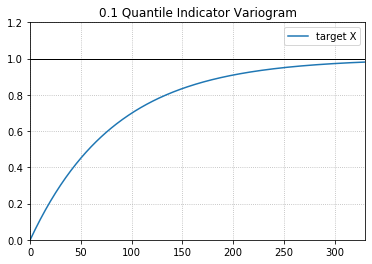

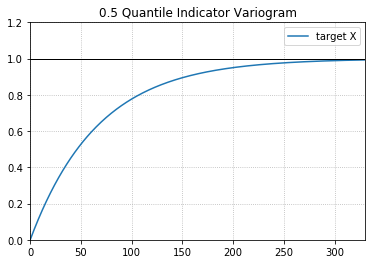

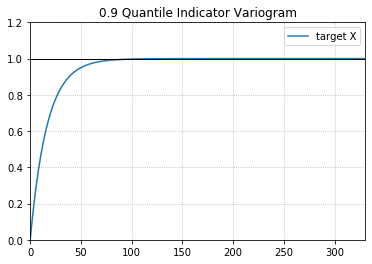

In [12]:
for q in quantiles:
    fig, ax = plt.subplots()
    ax.plot(ivarios[f"{q}_x"], label="target X")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * 0.66)
    ax.legend()

In [13]:
vtype_t = [2, 2]
xranges_t = [50, 300]
# xranges_t = [50, 300]
c0 = 0.001
cc = [0.5, 0.499]
cmax = c0 + np.sum(cc)
nst = len(vtype_t)

In [14]:
EPS = 1e-5
cova = np.zeros((nxy, nxy))
for i in range(nst):
    Q = P.copy()
    Q[:, 0] = Q[:, 0] / xranges_t[i]
    d = sps.distance_matrix(Q, Q)
    cova = cova + cc[i] * sim.covar(vtype_t[i], d, r=1)
cova[d < EPS] = cmax

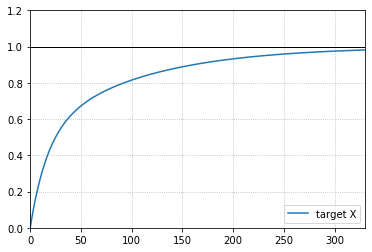

In [15]:
target_x = 1 - cova[0:nx, 0]

fig, ax = plt.subplots()
ax.plot(target_x, label="target X")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.66)
ax.legend(loc=4)

# Runs
- Load mixture from previous notebook

In [16]:
arr = np.load("network_mixture.npy")
iarr = np.load("network_mixture_indicators.npy")

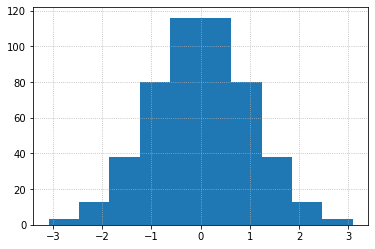

In [17]:
_ = plt.hist(arr)

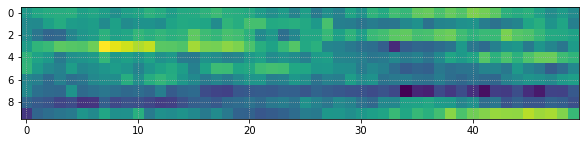

In [18]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(arr.reshape(10, 50), vmin=-3, vmax=3)

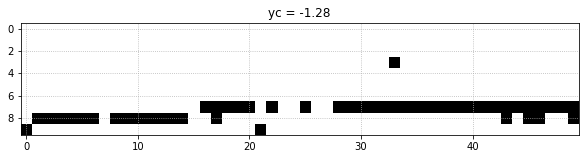

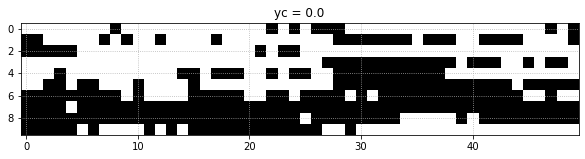

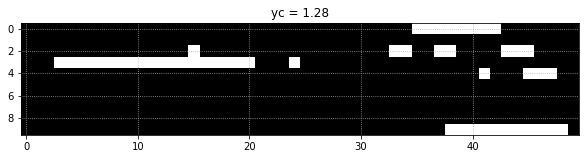

In [19]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots(figsize=(10, 9))
    im = ax.imshow(iarr[:, j].reshape(10, 50), vmin=0, vmax=1, cmap="binary")
    plt.title(f"yc = {np.round(c, 2)}")

In [20]:
@jit(nopython=True)
def init_ecdf(xvals, wts, nhist):
    """initilize emperical cdf from input array"""
    #     if wts is None:
    #         wts = np.ones(len(xvals)) / len(xvals)
    #     else:
    #         wts = wts / np.sum(wts)

    wts = np.ones(len(xvals)) / len(xvals)

    # calculate ecdf from xvals
    pvals = np.array([i / (nhist + 1) for i in range(1, nhist + 1)])
    order = xvals.argsort()
    cdf_x = xvals[order]
    cdf_y = np.cumsum(wts[order])
    cdf_y = cdf_y - cdf_y[0] / 2
    zvals = np.interp(pvals, cdf_y, cdf_x)

    # calculate actual fraction less than each pval
    frac = np.zeros(nhist)
    for x in cdf_x:
        for i in range(nhist):
            if x < zvals[i]:
                frac[i] += 1
    frac /= len(xvals)

    return zvals, frac

In [286]:
nhist = 200
runs_above = True
target_runs = {}
for j, q in enumerate(thresholds):
    runs = obj.binary_runs(iarr[:, j], runs_above=runs_above)["cum_runs"]
    target_runs[q], _ = init_ecdf(runs, wts=None, nhist=nhist)

In [287]:
runs

array([ 8,  7,  7,  6,  6,  6,  5,  5,  5,  5,  4,  4,  4,  4,  4,  3,  3,
        3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  1,  1,  2,  1,  1,  3,  2,  2,  1,  1,  1, 18, 17,
       17, 16, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 14, 13, 13, 13, 13,
       13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11,
       10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  3,  2,  2,  1

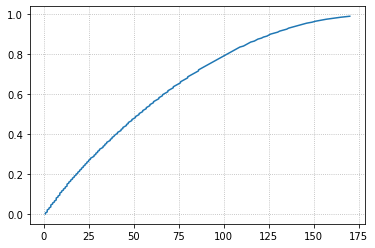

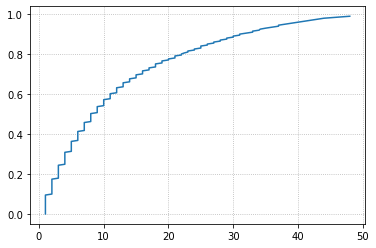

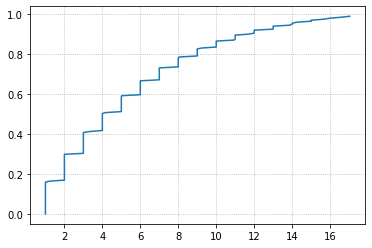

In [22]:
for j, q in enumerate(thresholds):
    fig, ax = plt.subplots()
    cruns = np.sort(target_runs[q])
    yy = np.arange(len(cruns)) / (len(cruns) + 1)
    _ = ax.plot(cruns, yy)

# n-Point Connectivity

In [23]:
@jit(nopython=True)
def n_pt_conn(x, nstep):
    """n-point connectivity fucntion of binary array x"""
    x = np.asarray(x)
    nx = x.shape[0]
    phi_n = np.zeros(nstep)
    for n in range(1, nstep + 1):
        prod = []
        for i in range(nx - n + 1):
            idxs = [i] + [j + i for j in range(n)]
            a = [x[int(idx)] for idx in idxs]
            p = 1
            for i in a:
                p *= i
            prod.append(p)
        phi_n[n - 1] = np.mean(np.array(prod))
    return np.asarray(phi_n)

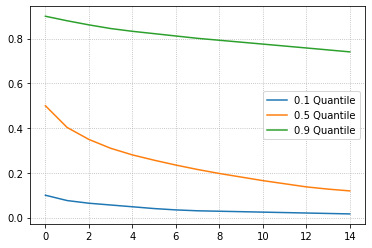

In [24]:
nstep = 15
target_npoint = {}
for j, q in enumerate(thresholds):
    target_npoint[q] = n_pt_conn(iarr[:, j], nstep=nstep)
    plt.plot(target_npoint[q], label=f"{q} Quantile")
    plt.legend()

# Factor Variogram Models

In [25]:
sph_fact = 5
exp_fact = 5
gau_fact = 5
n_fact = sph_fact + exp_fact + gau_fact

max_range = int(nx * 0.25)
min_range = int(nx * 0.025)

sph_ranges = np.linspace(min_range, max_range, num=sph_fact, endpoint=False)
exp_ranges = np.linspace(min_range, max_range, num=exp_fact, endpoint=False)
gau_ranges = np.linspace(min_range, max_range, num=gau_fact, endpoint=False)

sph_struct = [1] * sph_fact
exp_struct = [2] * exp_fact
gau_struct = [3] * gau_fact

ranges = np.concatenate((sph_ranges, exp_ranges, gau_ranges))
structs = np.concatenate((sph_struct, exp_struct, gau_struct))

In [26]:
structs

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [27]:
ranges

array([ 12. ,  34.6,  57.2,  79.8, 102.4,  12. ,  34.6,  57.2,  79.8,
       102.4,  12. ,  34.6,  57.2,  79.8, 102.4])

In [28]:
for i, (st, rnge) in enumerate(zip(structs, ranges)):
    print(i + 1, st, rnge)

1 1 12.0
2 1 34.6
3 1 57.2
4 1 79.80000000000001
5 1 102.4
6 2 12.0
7 2 34.6
8 2 57.2
9 2 79.80000000000001
10 2 102.4
11 3 12.0
12 3 34.6
13 3 57.2
14 3 79.80000000000001
15 3 102.4


# Factor Simulation
- Each initial factor is simulated with a different random number seed and a completely different variogram
- Each initial factor has a single pure structure that reflects something with unique spatial correlation that could translate to something combined with other factors

In [29]:
Y = np.zeros([nxy, n_fact + 1])
Y[:, 0] = rng.normal(size=nxy)
C = []
for i, (st, rnge) in enumerate(zip(structs, ranges)):
    if st < 3:
        cova = sim.pairwisecova_1D(
            P, ranges=[rnge], vtypes=[st], c0=0.0, cc=[1.0]
        )
    else:  # small nugget to avoid singular matrix with Gaussian model
        cova = sim.pairwisecova_1D(
            P, ranges=[rnge], vtypes=[st], c0=0.001, cc=[0.999]
        )
    Y[:, i + 1] = sim.lusim(cova, nr=1, seed=78451 + i * 1000)
    C.append(cova)

In [30]:
Y.shape

(500, 16)

-0.05 0.98
-0.15 1.06
-0.01 0.87
-0.38 1.35
0.27 1.08
-0.21 0.76
0.18 0.9
0.07 1.04
0.06 0.84
0.08 0.86
-0.13 0.71
0.11 0.87
-0.15 0.89
-0.04 0.78
-0.39 0.67
-0.52 1.05


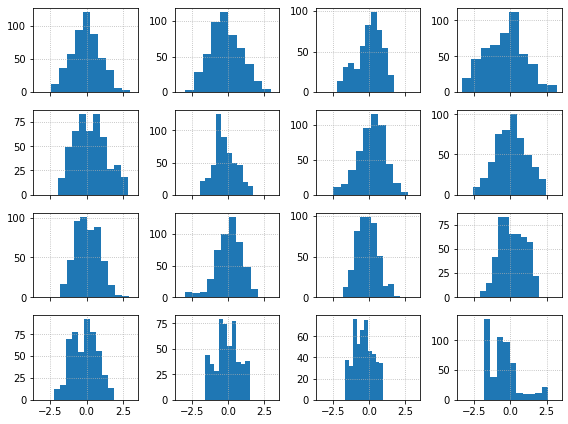

In [31]:
fig, axes = plt.subplots(4, 4, figsize=(8, 6), sharex="all")
for i, ax in enumerate(axes.flatten()):
    ax.hist(Y[:, i])
    print(np.round(np.mean(Y[:, i]), 2), np.round(np.std(Y[:, i]), 2))
fig.tight_layout()

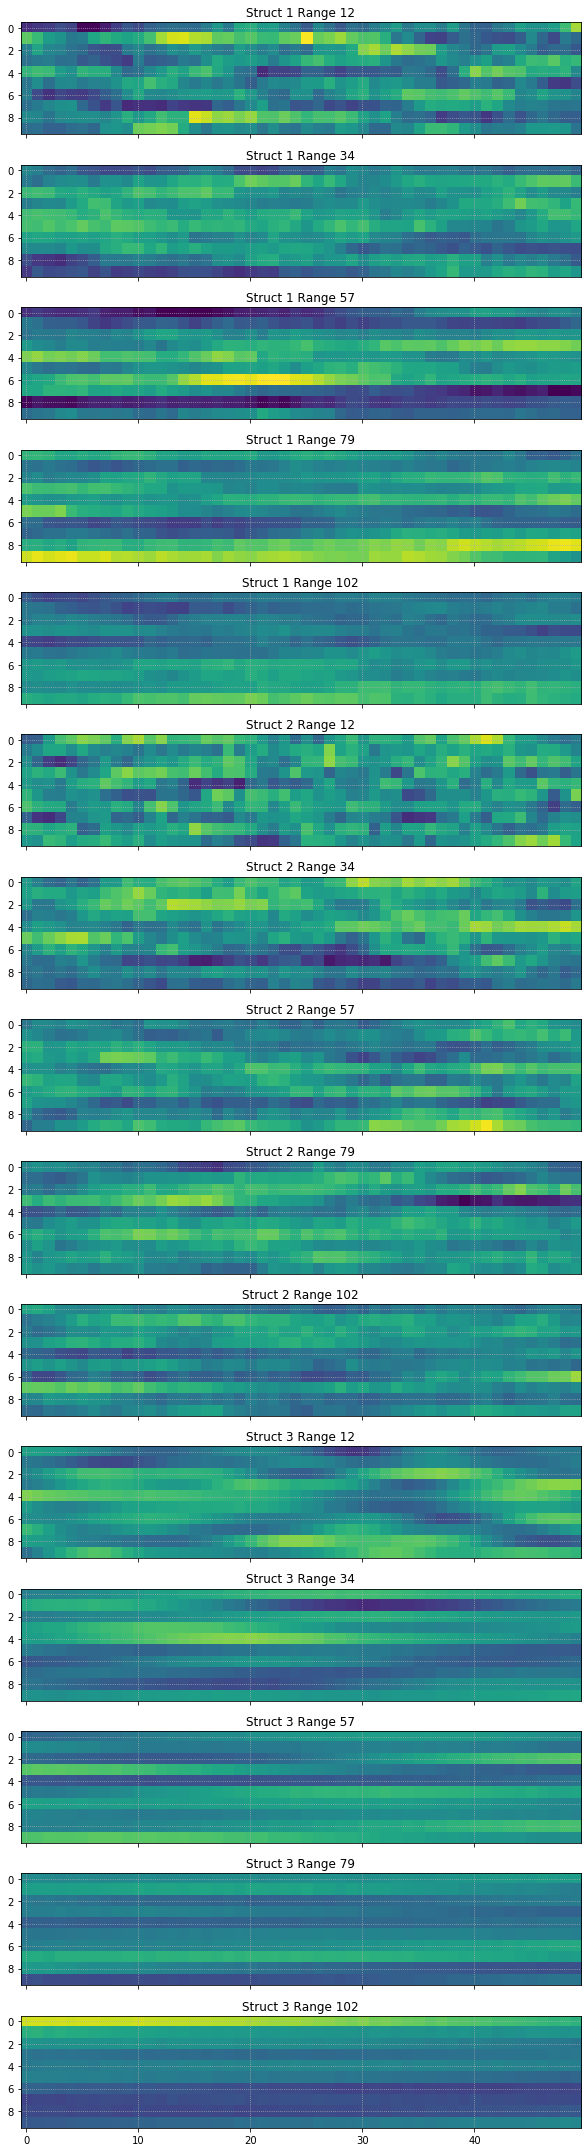

In [32]:
fig, axes = plt.subplots(15, 1, figsize=(10, 30), sharex="all")
for i, (ax, st, rnge) in enumerate(zip(axes.flatten(), structs, ranges)):
    ax.imshow(Y[:, i + 1].reshape(10, 50), vmin=-3, vmax=3)
    ax.set_title(f"Struct {st} Range {int(rnge)}")
fig.tight_layout()

# Network LMR
- Mix the pool of factors with the goal of reproducing the LMR
- Exponential factors of short and long-ish ranges should recive the most weight

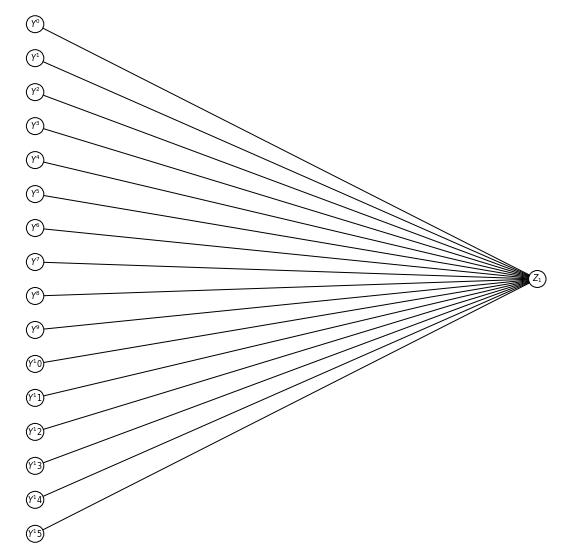

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis("off")
layer_dims = [n_fact + 1, 1]
# layer_dims = [n_fact + 1, 8, 4, 2, 1]
draw_neural_net(ax, 0.05, 0.95, 0.0, 1.0, layer_dims, "Y", "A", "Z", 8)

In [34]:
parameters = nn.intitialize_layer_params(layer_dims, 69420)

In [35]:
connections = []
for k, v in parameters.items():
    if "W" in k:
        connections.append(v.shape[0] * v.shape[1])
    print(k, "shape:", v.shape)
tconn = np.sum(connections)
print("Total connections:", tconn)

W1 shape: (1, 16)
b1 shape: (1, 1)
Total connections: 16


In [36]:
AL = nn.linear_forward(Y, parameters, nn.relu)

In [37]:
AL.shape

(500,)

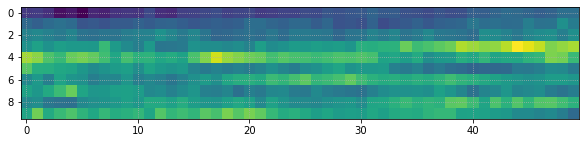

In [38]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(AL.reshape(10, 50), vmin=-3, vmax=3)

In [39]:
AL_i, ivars = obj.indicator_transform(AL, yc)

0.09000000000000001
0.25
0.08999999999999998


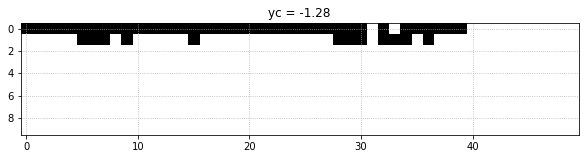

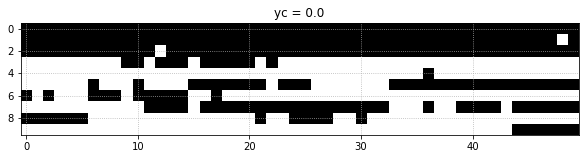

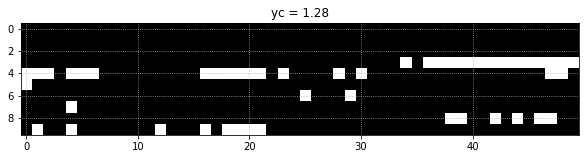

In [40]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots(figsize=(10, 9))
    print(ivars[j])
    im = ax.imshow(AL_i[:, j].reshape(10, 50), vmin=0, vmax=1, cmap="binary")
    plt.title(f"yc = {np.round(c, 2)}")

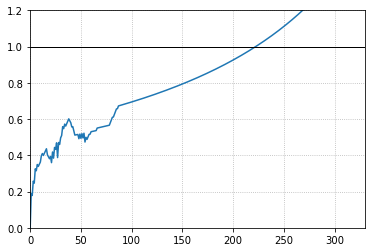

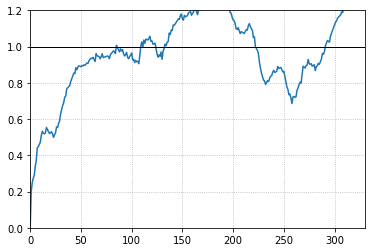

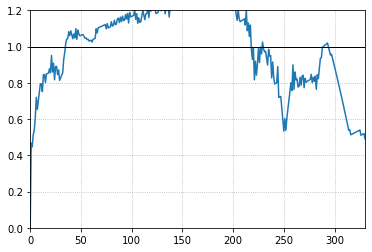

In [41]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots()
    gx = obj.griddedgam(AL_i[:, j])
    ax.plot(gx / ivars[j])
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * 0.66)

In [42]:
thresholds

{0.1: -1.2815515655446004, 0.5: 0.0, 0.9: 1.2815515655446004}

# Optimize

## Utils

In [202]:
def vector_to_matrices(parameters, connections, x):
    """reshape 1D vector into appropriate matrices"""
    L = len(parameters) // 2
    num_wts = np.cumsum([0] + connections)
    for ell in range(1, L + 1):
        shape = parameters["W" + str(ell)].shape
        parameters["W" + str(ell)] = x[num_wts[ell - 1] : num_wts[ell]].reshape(
            shape
        )
    return parameters


def indicator_transform(z, zc):
    """indicator transform of z based on cutoffs zc"""
    z = z.flatten()
    zi = np.zeros((len(z), len(zc)))
    ivars = []
    for j, c in enumerate(zc):
        zi[:, j] = np.where(z <= c, 1, 0)
        iprop = np.mean(zi[:, j])
        ivars.append(iprop * (1 - iprop))
    return zi, ivars

## Variograms

In [203]:
def check_twod(z):
    twod = False
    ndim = z.shape
    if len(ndim) > 1:
        if ndim[1] > 1:
            twod = True
    return twod


def griddedgam(z):
    """gridded variogram values"""
    if check_twod(z):
        gx = griddedgam_x(z)
        gy = griddedgam_y(z)
        return gx, gy
    else:
        return griddedgam_x(z)


def griddedgam_x(z):
    """gridded variogram values along x axis"""
    nx = z.shape[0]
    gx = np.zeros(nx - 1)
    for i in range(1, nx - 1):
        z0 = z[0 : nx - i]
        z1 = z[i:nx]
        dz = (z1 - z0) ** 2
        gx[i] = np.sum(dz) / (2 * (nx - i))
    return gx


def griddedgam_y(z):
    """gridded variogram values along y axis"""
    ny = z.shape[1]
    gy = np.zeros(ny - 1)
    for i in range(1, ny - 1):
        z0 = z[0 : ny - i, :]
        z1 = z[i:ny, :]
        dz = (z1 - z0) ** 2
        gy[i] = np.sum(dz) / (2 * (ny - i))
    return gy


def vario_loss(true, pred, i, j, lag_wts):
    """squared error between predicted and target variogram"""
    return np.sum(((pred[i:j] - true[i:j]) * lag_wts[i:j]) ** 2)

## Runs

In [204]:
def binary_runs(x, runs_above):
    """Calcualte runs and cumulative runs in binary array x"""
    runs_data = {}
    x = np.asarray(x)
    first_run = x[0]  # 1 or 0
    runstart = np.nonzero(np.diff(np.r_[[-np.inf], x, [np.inf]]))[0]
    runs = np.diff(runstart)
    runs = _check_runs_above(first_run, runs, runs_above)
    cum_runs = []
    for run in runs:
        for i in range(run):
            sub_run_length = run - i
            num_sub_runs = i + 1
            cum_runs.append([*[sub_run_length] * num_sub_runs])

    runs_data["runs"] = runs
    runs_data["cum_runs"] = np.array([a for b in cum_runs for a in b])
    runs_data["run_idxs"] = runstart
    runs_data["n_runs"] = len(runs)

    try:  # catch situation where all runs are below/above?
        runs_data["cum_runs_freqs"] = np.bincount(runs_data["cum_runs"])[1:]
        runs_data["runs_freqs"] = np.bincount(runs)[1:]
    except:
        runs_data["cum_runs_freqs"] = np.array([])
        runs_data["runs_freqs"] = np.array([])

    return runs_data


def _check_runs_above(first_run, runs, runs_above=True):
    if runs_above:
        if first_run:
            runs = runs[1::2]
        else:
            runs = runs[0::2]
        return runs
    else:
        return runs

## Objective

In [222]:
#
# variograms
#


def objective_vario(AL, target, nx, ny, i, j, scale=1.0):
    """continuous variogram objective function"""
    twod = False
    if ny > 1:
        twod = True
    lag_wts = 1 - np.exp(10 / -np.arange(1, nx))  # 10 is arbitrary
    objv = 0.0
    if twod:
        tx, ty = target[:, 0], target[:, 1]
        gx, gy = griddedgam(AL.reshape(ny, nx))
        objv = vario_loss(tx, gx, i, j, lag_wts)
        objv += vario_loss(ty, gy, i, j, lag_wts)
    else:
        gx = griddedgam(AL)
        objv = vario_loss(target, gx, i, j, lag_wts)
    return objv * scale


def init_vario(
    Y, target, nx, ny, connections, parameters, bounds, afunc, seed,
):
    """initialize continuous variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_vario(AL, target, nx, ny, i=0, j=nx - 1, scale=1.0)
    return objv


#
# indicator variograms
#


def objective_ivario(AL, target, thresholds, nx, ny, ii, jj, scale=1.0):
    """indicator variogram objective function"""
    twod = False
    if ny > 1:
        twod = True
    lag_wts = 1 - np.exp(10 / -np.arange(1, nx))  # 10 is arbitrary
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    if twod:
        for k, q in enumerate(quantiles):
            tx, ty = target[f"{q}_x"], target[f"{q}_y"]
            gx, gy = griddedgam(AL_i[:, k].reshape(ny, nx))
            objv = vario_loss(tx, gx / ivars[k], ii[k], jj[k], lag_wts)
            objv += vario_loss(ty, gy / ivars[k], ii[k], jj[k], lag_wts)
    else:
        for k, q in enumerate(quantiles):
            gx = griddedgam(AL_i[:, k])
            objv += vario_loss(
                target[f"{q}_x"], gx / ivars[k], ii[k], jj[k], lag_wts
            )
    return objv * scale


def init_ivario(
    Y, target, nx, ny, thresholds, connections, parameters, bounds, afunc, seed,
):
    """initialize indicator variogram objective function"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_ivario(
        AL,
        target,
        thresholds,
        nx,
        ny,
        ii=[0] * len(thresholds),
        jj=[nx - 1] * len(thresholds),
        scale=1.0,
    )
    return objv


#
# runs
#


def objective_histogram(arr, target, wts, nhist, scale):
    """histogram objective function component"""
    zvals, _ = init_ecdf(arr, wts, nhist)
    objv = 0.0
    objv += np.sum((zvals - target) ** 2)
    return objv * scale


def init_runs(
    Y,
    target,
    thresholds,
    runs_above,
    connections,
    parameters,
    bounds,
    afunc,
    seed,
):
    """initialize runs objective"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_runs(
        AL, target, thresholds, runs_above, wts=None, nhist=200, scale=1.0
    )
    return objv


def objective_runs(AL, target, thresholds, runs_above, wts, nhist, scale):
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    for j, q in enumerate(thresholds):
        runs = binary_runs(AL_i[:, j], runs_above)["cum_runs"]
        objv += objective_histogram(runs, target[q], wts, nhist, scale)
    return objv


#
# n-point connectivity
#


def objective_npoint(AL, target, thresholds, nstep, scale):
    AL_i, ivars = indicator_transform(AL, thresholds.values())
    objv = 0.0
    for j, q in enumerate(thresholds):
        npoint = n_pt_conn(AL_i[:, j], nstep)
        objv += np.sum((npoint - target[q]) ** 2)
    return objv * scale


def init_npoint(
    Y, target, thresholds, nstep, connections, parameters, bounds, afunc, seed
):
    """initialize n-point connectivity objective"""
    rng = np.random.default_rng(seed)
    x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))
    parameters = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, parameters, afunc)
    objv = objective_npoint(AL, target, thresholds, nstep, scale=1.0)
    return objv

### Scaling

In [223]:
def objective_scaling(
    Y,
    nx,
    ny,
    connections,
    parameters,
    bounds,
    thresholds,
    runs_above,
    wts,
    nhist,
    nstep,
    afunc,
    maxpert,
    seed,
    vario=True,
    vario_target=None,
    ivario=True,
    ivario_target=None,
    runs=True,
    runs_target=None,
    npoint=True,
    npoint_target=None,
):
    rng = np.random.default_rng(seed)

    objinit = np.zeros(4)
    objscale = np.ones(4)
    objdelta = np.zeros(4)

    # initalize objective values
    if vario:
        objinit[0] = init_vario(
            Y,
            vario_target,
            nx,
            ny,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if ivario:
        objinit[1] = init_ivario(
            Y,
            ivario_target,
            nx,
            ny,
            thresholds,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if runs:
        objinit[2] = init_runs(
            Y,
            runs_target,
            thresholds,
            runs_above,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )
    if npoint:
        objinit[3] = init_npoint(
            Y,
            npoint_target,
            thresholds,
            nstep,
            connections,
            parameters,
            bounds,
            afunc,
            seed,
        )

    for m in range(maxpert):

        # draw random parameter vector
        x = rng.uniform(bounds[0], bounds[1], size=np.sum(connections))

        # reshape x into matrices
        parameters = vector_to_matrices(parameters, connections, x)

        # caluclate the forward pass
        AL = nn.linear_forward(Y, parameters, afunc)

        # approximate objective contributions
        if vario:
            temp_obj_vario = objective_vario(
                AL, vario_target, nx, ny, i=0, j=nx - 1, scale=objscale[0]
            )
            if temp_obj_vario < 0.0:
                temp_obj_vario = objinit[0]
            objdelta[0] += np.abs(objinit[0] - temp_obj_vario)

        if ivario:
            temp_obj_ivario = objective_ivario(
                AL,
                ivario_target,
                thresholds,
                nx,
                ny,
                ii=[0] * len(thresholds),
                jj=[nx - 1] * len(thresholds),
                scale=objscale[1],
            )
            if temp_obj_ivario < 0.0:
                temp_obj_ivario = objinit[1]
            objdelta[1] += np.abs(objinit[1] - temp_obj_ivario)

        if runs:
            temp_obj_runs = objective_runs(
                AL,
                runs_target,
                thresholds,
                runs_above,
                wts,
                nhist,
                scale=objscale[2],
            )
            if temp_obj_runs < 0.0:
                temp_obj_runs = objinit[2]
            objdelta[2] += np.abs(objinit[2] - temp_obj_runs)

        if npoint:
            temp_obj_npt = objective_npoint(
                AL, npoint_target, thresholds, nstep, scale=objscale[3],
            )
            if temp_obj_npt < 0.0:
                temp_obj_npt = objinit[3]
            objdelta[3] += np.abs(objinit[3] - temp_obj_npt)

    # scale objective components
    if vario:
        objscale[0] = maxpert / objdelta[0]
    if ivario:
        objscale[1] = maxpert / objdelta[1]
    if runs:
        objscale[2] = maxpert / objdelta[2]
    if npoint:
        objscale[3] = maxpert / objdelta[3]

    # rescale factor
    rescale = 0.0
    for objv, scl in zip(objinit, objscale):
        rescale += scl * objv
    rescale = 1 / max(rescale, 1e-10)
    objscale *= rescale

    return objscale

In [224]:
afunc = nn.relu
bounds = (0, 1)
wts = None
runs_above = True

objscale = objective_scaling(
    Y,
    nx,
    ny,
    connections,
    parameters,
    bounds,
    thresholds,
    runs_above,
    wts,
    nhist,
    nstep,
    afunc,
    maxpert=1000,
    seed=123,
    vario=True,
    vario_target=target_x,
    ivario=True,
    ivario_target=ivarios,
    runs=True,
    runs_target=target_runs,
    npoint=True,
    npoint_target=target_npoint,
)
print(objscale)

[2.87643267e-01 6.10333024e-02 5.48111953e-07 9.83310174e-01]


In [221]:
sum(objscale)

1.3319872911442396

### Optimize Network

In [225]:
def network_lmr_objective_1D(x, *args):
    """objective function for network lmr"""

    # caluclate the forward pass
    params = vector_to_matrices(parameters, connections, x)
    AL = nn.linear_forward(Y, params, afunc)

    # calculate sum of squares
    objv = 0.0

    # continuous variogram
    objv += objective_vario(AL, target_vario, nx, ny, i, j, objscale[0])

    # indicator variogram
    objv += objective_ivario(
        AL, target_ivario, thresholds, nx, ny, ii, jj, objscale[1]
    )

    # cumulative runs
    objv += objective_runs(
        AL, target_runs, thresholds, runs_above, wts, nhist, objscale[2]
    )

    # npoint connectivity runs
    objv += objective_npoint(AL, target_npoint, thresholds, nstep, objscale[3])

    return objv

In [255]:
target_vario = target_x
target_ivario = ivarios
i = 0
j = 200
ii = [0] * len(ivarios)
jj = [nx - 1] * len(ivarios)
# objscale = objscale * [100, 100, 1, 0.001]
objscale = [1, 1, 1, 1]
print(objscale)


args = (
    parameters,
    connections,
    Y,
    nx,
    ny,
    i,
    j,
    ii,
    jj,
    target_vario,
    target_ivario,
    target_runs,
    target_npoint,
    wts,
    nhist,
    nstep,
    runs_above,
    thresholds,
    afunc,
    objscale,
)
results = list(
    opt.de(
        network_lmr_objective_1D,
        args,
        bounds=[bounds] * tconn,
        popsize=15,
        mut=0.7,
        crossp=0.9,
        its=300,
        seed=21,
    )
)

[1, 1, 1, 1]


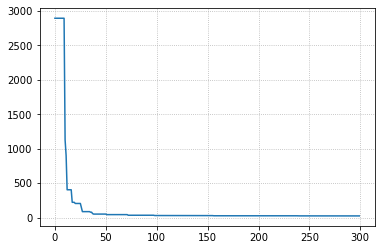

In [256]:
objective = []
for result in results:
    objective.append(result[-1])
plt.plot(objective)

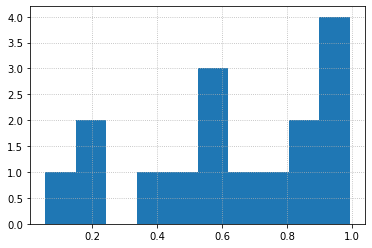

In [257]:
_ = plt.hist(results[-1][0])

In [258]:
results[-1]

(array([0.35505625, 0.185173  , 0.56813779, 0.61811827, 0.15815516,
        0.05506428, 0.99312934, 0.5341381 , 0.86766259, 0.48110373,
        0.94327891, 0.99291194, 0.99284274, 0.52923131, 0.88166362,
        0.78054861]),
 24.89671273571233)

In [259]:
len(results)

300

In [260]:
de_params = parameters.copy()
de_weights = []
num_wts = np.cumsum([0] + connections)
for ell in range(1, len(parameters) // 2 + 1):
    shape = de_params["W" + str(ell)].shape
    de_params["W" + str(ell)] = results[-1][0][
        num_wts[ell - 1] : num_wts[ell]
    ].reshape(shape)
    de_weights.append(de_params["W" + str(ell)])

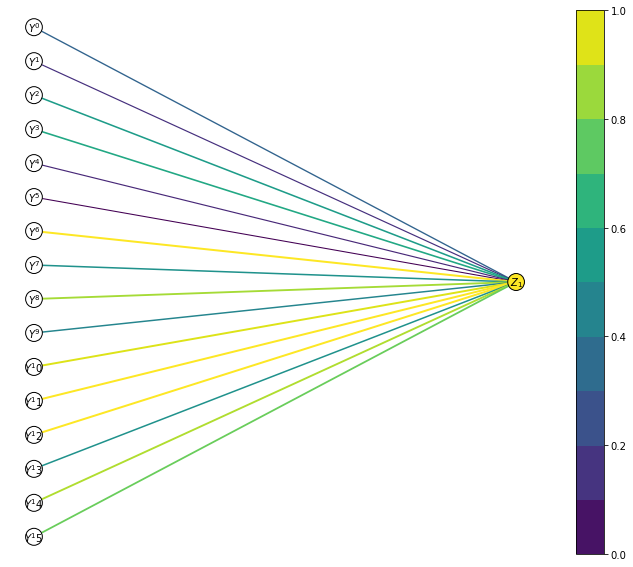

In [261]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")
cmap = "viridis"  # "Spectral_r"
draw_weighted_neural_net(
    ax,
    0.05,
    0.95,
    0.0,
    1.0,
    layer_dims,
    "Y",
    "A",
    "Z",
    10,
    node_wts=de_weights,
    edge_wts=de_weights,
    cmap=cmap,
)
sm, _ = get_rgb(0, cmap, 0, 1)
plt.colorbar(sm, boundaries=np.arange(0, 1.1, 0.1))

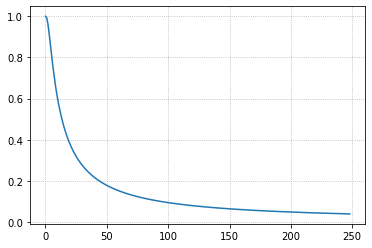

In [262]:
testx = np.arange(1, 250)
plt.plot(1 - np.exp(10 / -testx))

# Summarize Results

In [263]:
de_AL = nn.linear_forward(Y, de_params, afunc)
de_AL_i, ivars = obj.indicator_transform(de_AL, yc)
gx = obj.griddedgam(de_AL)

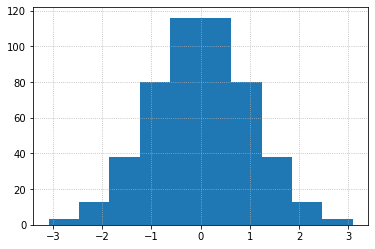

In [264]:
_ = plt.hist(de_AL)

In [265]:
def core_tray_plot(
    z, len_rows, nrows, cmap="viridis", clim=(-2.5, 2.5), figsize=(10, 3)
):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(
        z.reshape(nrows, len_rows), vmin=clim[0], vmax=clim[1], cmap=cmap
    )
    plt.colorbar(im, ax=ax)
    return ax

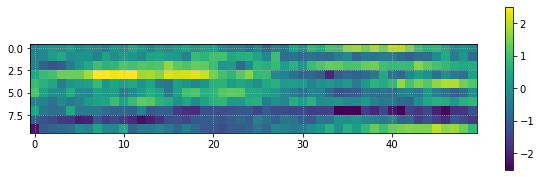

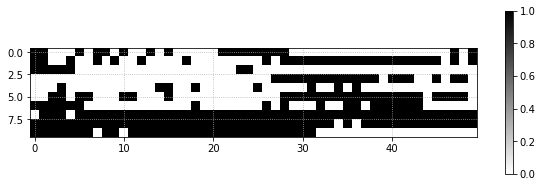

In [266]:
core_tray_plot(de_AL, 50, 10)
core_tray_plot(
    np.where(de_AL > thresholds[0.5], 0, 1),
    cmap="binary",
    clim=(0, 1),
    len_rows=50,
    nrows=10,
)

## Variograms

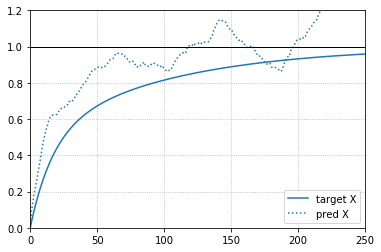

In [267]:
fig, ax = plt.subplots()
ax.plot(target_vario, c="C0", label="target X")
ax.plot(gx, c="C0", ls=":", label="pred X")
ax.axhline(1.0, c="k", lw=1)
ax.set_ylim(0, 1.2)
ax.set_xlim(0, nx * 0.5)
ax.legend()

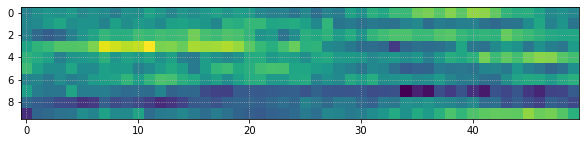

In [268]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(de_AL.reshape(10, 50), vmin=-3, vmax=3)

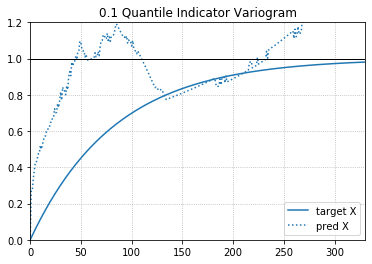

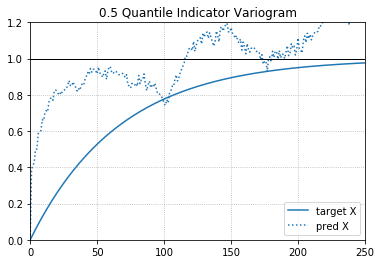

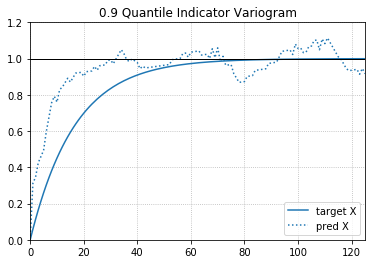

In [269]:
xscale = [0.66, 0.5, 0.25]
for j, q in enumerate(quantiles):
    fig, ax = plt.subplots()
    gxi = griddedgam(de_AL_i[:, j])
    ax.plot(target_ivario[f"{q}_x"], c="C0", label="target X")
    ax.plot(gxi / ivars[j], c="C0", ls=":", label="pred X")
    ax.set_title(f"{q} Quantile Indicator Variogram")
    ax.axhline(1.0, c="k", lw=1)
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0, nx * xscale[j])
    ax.legend()

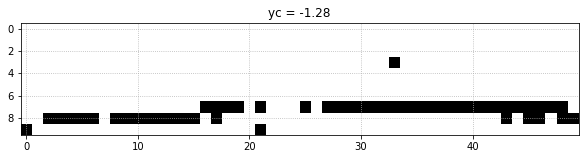

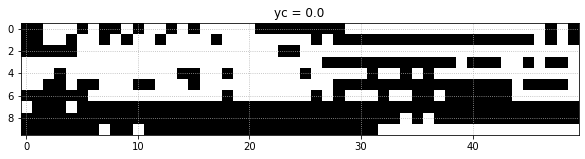

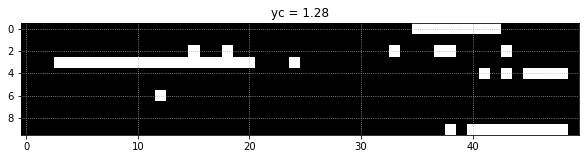

In [270]:
for j, c in enumerate(yc):
    fig, ax = plt.subplots(figsize=(10, 9))
    im = ax.imshow(de_AL_i[:, j].reshape(10, 50), vmin=0, vmax=1, cmap="binary")
    plt.title(f"yc = {np.round(c, 2)}")

 ## Runs

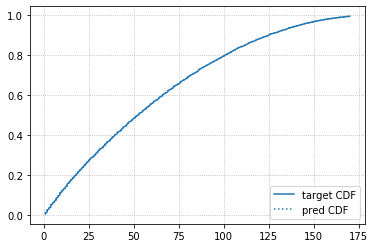

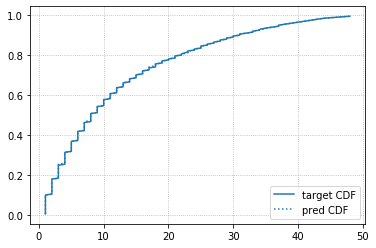

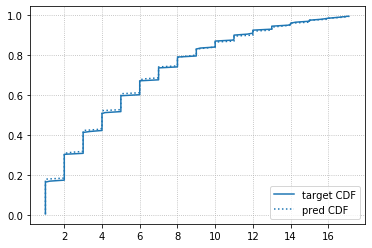

In [271]:
for j, q in enumerate(thresholds):
    fig, ax = plt.subplots()
    target_cruns = np.sort(target_runs[q])
    cruns = binary_runs(de_AL_i[:, j], runs_above=True)["cum_runs"]
    cruns, _ = init_ecdf(cruns, wts=None, nhist=nhist)
    pvals = [i / (nhist + 1) for i in range(1, nhist + 1)]
    ax.plot(target_cruns, pvals, label="target CDF")
    ax.plot(cruns, pvals, ls=":", c="C0", label="pred CDF")
    ax.legend(loc=4)

## n-Point Connectivity

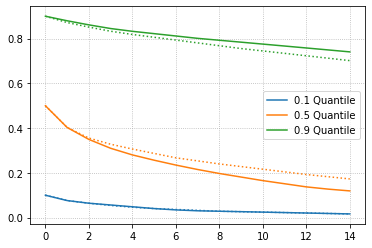

In [272]:
for j, q in enumerate(thresholds):
    npoint = n_pt_conn(de_AL_i[:, j], nstep=nstep)
    plt.plot(target_npoint[q], c=f"C{j}", label=f"{q} Quantile")
    plt.plot(npoint, c=f"C{j}", ls=":")
    plt.legend()

## Reference vs Mixture

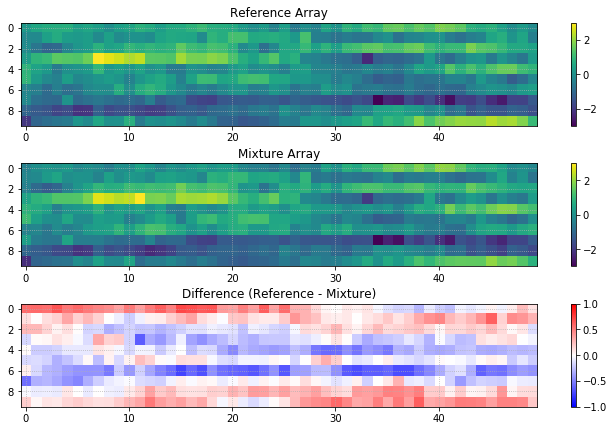

In [278]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
im0 = axes[0].imshow(arr.reshape(10, 50), vmin=-3, vmax=3)
axes[0].set_title("Reference Array")
im1 = axes[1].imshow(de_AL.reshape(10, 50), vmin=-3, vmax=3)
axes[1].set_title("Mixture Array")
im2 = axes[2].imshow((arr - de_AL).reshape(10, 50), vmin=-1, vmax=1, cmap="bwr")
axes[2].set_title("Difference (Reference - Mixture)")

plt.colorbar(im0, ax=axes[0])
plt.colorbar(im1, ax=axes[1])
plt.colorbar(im2, ax=axes[2])

fig.tight_layout()

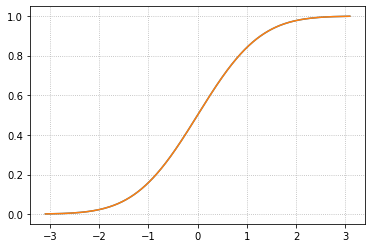

In [274]:
def ecdf(xvals):
    wts = np.ones(len(xvals)) / len(xvals)
    order = xvals.argsort()
    cdf_x = xvals[order]
    cdf_y = np.cumsum(wts[order])
    cdf_y = cdf_y - cdf_y[0] / 2
    return cdf_x, cdf_y


fig, ax = plt.subplots()
_ = ax.plot(*ecdf(arr))
_ = ax.plot(*ecdf(de_AL))

In [275]:
np.sum((arr - de_AL) ** 2)

44.00078130036852

In [279]:
target_runs

{0.1: array([  1.        ,   1.        ,   2.        ,   2.        ,
          2.        ,   3.        ,   3.        ,   4.        ,
          4.        ,   4.        ,   5.        ,   5.        ,
          6.        ,   6.        ,   7.        ,   7.        ,
          7.        ,   8.        ,   8.        ,   9.        ,
          9.        ,   9.        ,  10.        ,  10.        ,
         11.        ,  11.        ,  12.        ,  12.        ,
         13.        ,  13.        ,  13.        ,  14.        ,
         14.        ,  15.        ,  15.        ,  16.        ,
         16.        ,  17.        ,  17.        ,  18.        ,
         18.        ,  19.        ,  19.        ,  20.        ,
         20.        ,  21.        ,  21.        ,  22.        ,
         22.        ,  23.        ,  23.        ,  24.        ,
         24.        ,  25.        ,  25.        ,  26.        ,
         26.        ,  27.        ,  28.        ,  28.        ,
         29.        ,  29.        ,

In [276]:
# from numba import njit

# @njit
# def rseed(a):
#     np.random.seed(a)

# @njit
# def uniform(low=0.0, high=1.0, size=None):
#     return np.random.uniform(low, high, size)

# @njit
# def integers(low, high=None):
#     return np.random.randint(low, high)

# @njit
# def choice(a, size=None, replace=True):
#     return np.random.choice(a, size, replace)


# def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=20, its=1000, seed=515151):
#     """differential evolotuion of fobj"""
#     rseed(seed)
#     dimensions = len(bounds)
#     pop = uniform(size=(popsize, dimensions))
#     min_b, max_b = np.asarray(bounds).T
#     diff = np.fabs(min_b - max_b)
#     pop_denorm = min_b + pop * diff
#     fitness = np.asarray([fobj(ind) for ind in pop_denorm])
#     best_idx = np.argmin(fitness)
#     best = pop_denorm[best_idx]
#     for i in range(its):
#         for j in range(popsize):
#             idxs = np.array([idx for idx in range(popsize) if idx != j])
#             a, b, c = pop[choice(idxs, 3, replace=False)]
#             mutant = np.clip(a + mut * (b - c), 0, 1)
#             cross_points = uniform(size=dimensions) < crossp
#             if not np.any(cross_points):
#                 cross_points[integers(0, dimensions)] = True
#             trial = np.where(cross_points, mutant, pop[j])
#             trial_denorm = min_b + trial * diff
#             f = fobj(trial_denorm)
#             if f < fitness[j]:
#                 fitness[j] = f
#                 pop[j] = trial
#                 if f < fitness[best_idx]:
#                     best_idx = j
#                     best = trial_denorm
#         yield best, fitness[best_idx]

In [277]:
# @njit
# def add(x, y):
#     return x + y


# @njit
# def subtract(x, y):
#     return x - y


# @njit
# def multiply(x, y):
#     return x * y


# @njit
# def divide(x, y):
#     return x / y


# @njit
# def fobj(z):
#     x, y, = z
#     obj = 0.0
#     obj += add(x, y)
#     obj += subtract(x, y)
#     obj += multiply(x, y)
#     obj += divide(x, y)
#     return obj


# results = list(
#     de(
#         fobj,
#         bounds=[(-0.1, 0.1), (-0.1, 0.1)],
#         popsize=15,
#         mut=0.7,
#         crossp=0.9,
#         its=10,
#         seed=21,
#     )
# )

# objective = []
# for result in results:
#     objective.append(result[-1])
# plt.plot(objective)